# 1. Load data

In [1]:
from src.dataloaders import FPathLazyDataset

mask_threshold = 0.99

train_dset = FPathLazyDataset(config_path="dataset/train3.yaml", mask_threshold=mask_threshold)
val_dset = FPathLazyDataset(config_path="dataset/val3.yaml", mask_threshold=mask_threshold)
test_dset = FPathLazyDataset(config_path="dataset/test3.yaml", mask_threshold=mask_threshold, test=True)

wind_dset = FPathLazyDataset(config_path="dataset/wild_test.yaml", mask_threshold=mask_threshold, test=True)

# 2. Visualize sample data

In [2]:
data = wind_dset[0]
# vtf, img, infodraw, target, mask = data["vtf"], data["img"], data["infodraw"], data["target"], data["mask"]
# print(f"vtf.shape: {vtf.shape}, img.shape: {img.shape}, infodraw.shape: {infodraw.shape}, target.shape: {target.shape}, mask.shape: {mask.shape}")

vtf, img, infodraw, mask = data["vtf"], data["img"], data["infodraw"], data["mask"]
print(f"vtf.shape: {vtf.shape}, img.shape: {img.shape}, infodraw.shape: {infodraw.shape}, mask.shape: {mask.shape}")

vtf.shape: (21, 600, 800), img.shape: torch.Size([3, 600, 800]), infodraw.shape: torch.Size([1, 600, 800]), mask.shape: torch.Size([1, 600, 800])


(-0.5, 3199.5, 599.5, -0.5)

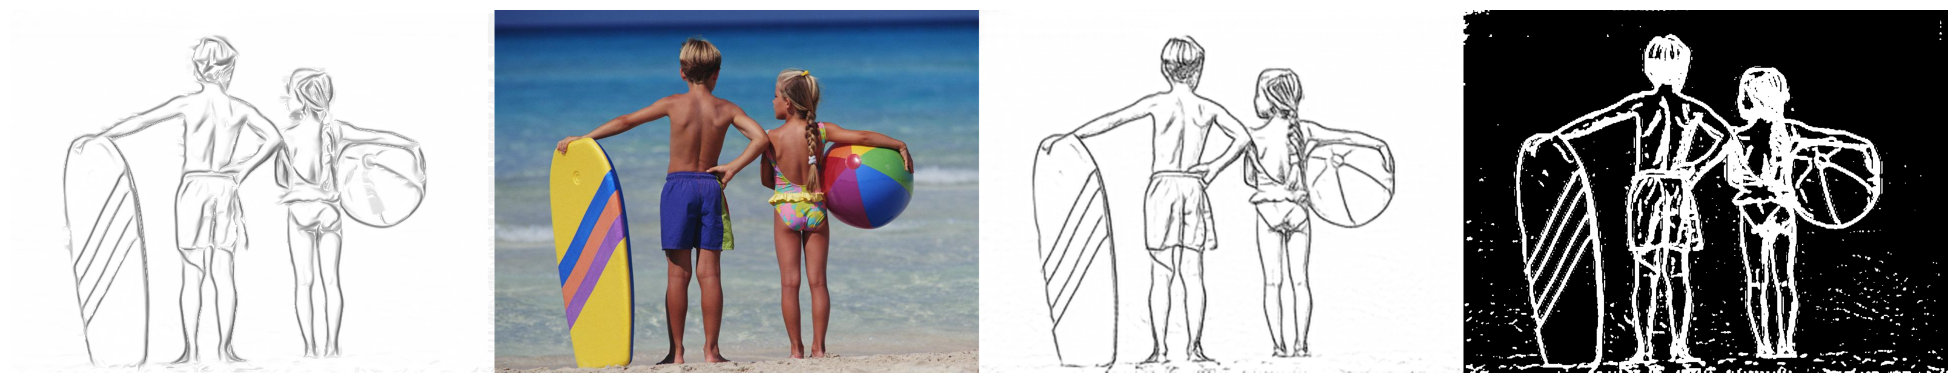

In [3]:
import matplotlib.pyplot as plt
import numpy as np

vtf_vis = np.repeat(np.mean(vtf, axis=0, keepdims=True), 3, axis=0)
img_vis = np.array(img)
infodraw_vis = np.repeat(infodraw, 3, axis=0)
# target_vis = np.repeat(target, 3, axis=0)
mask_vis = np.repeat(mask, 3, axis=0)

# samples = np.concatenate([vtf_vis, img_vis, infodraw_vis, target_vis, mask_vis], axis=2)
samples = np.concatenate([vtf_vis, img_vis, infodraw_vis, mask_vis], axis=2)
plt.figure(figsize=(25, 5))
plt.imshow(np.transpose(samples, (1, 2, 0)))
plt.axis("off")

# 3. Define a Model

# 4. Train

### define train & evaluation

In [4]:
import torch
import torch.optim as optim

from torch.utils.data import DataLoader
from tqdm import tqdm

from src.losses import MaskedBCELoss
from src.target_enhancer import TargetEnhancer
from src.models import FCNet



def train(model, criterion, optimizer, train_dloader, device):
    model.train()
    losses = []
    for batch in tqdm(train_dloader):
        vtf, target, mask = batch["vtf"].to(device), batch["target"].to(device), batch["mask"].to(device)
        
        output = model(vtf)
        
        loss = criterion(output, target, mask)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return losses

def evaluate(model, val_dloader, device):
    model.eval()
    for batch in tqdm(val_dloader):
        vtf, target, mask = batch["vtf"].to(device), batch["target"].to(device), batch["mask"].to(device)
        
        output = model(vtf)
        
        output_bin = output > 0.5 # 0.5 이하는 검정 (sketch)
        
        truth_table = mask * (output_bin == target)
        accuracy = torch.sum(truth_table) / torch.sum(mask)
        
        return accuracy

## 4.1. Overfit on validataion set

In [ ]:
EPOCHS = 20 # 6에폭도 충분함.
device = "cuda:0"
ENHANCE_ITERATION = 100

target_enhancer = TargetEnhancer()

model = FCNet()
model.load_state_dict(torch.load("weights/train3_model.pth")) # trained on full training dset
model = model.to(device)
model.eval()

criterion = MaskedBCELoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

small_dset = FPathLazyDataset(config_path="dataset/val_small.yaml", mask_threshold=mask_threshold)
small_dloader = DataLoader(dataset=small_dset, batch_size=4, shuffle=False, num_workers=8)

for enhance_iter in range(ENHANCE_ITERATION+1):
    
    # 1. train
    for epoch in range(1, EPOCHS+1):
        losses = train(model, criterion, optimizer, small_dloader, device)
        accuracy = evaluate(model, small_dloader, device)
        
        print(f"epoch: {epoch:3d} || train loss: {np.mean(losses)}, val accuracy: {100 * accuracy}")
    
    # save model
    torch.save(model.state_dict(), f"train3_model_enhance_iter_{enhance_iter}.pth")
    
    # 2. enhance targets
    small_dset = target_enhancer.enhance_target(small_dset, model, enhance_iter, device)
    
    # 3. state new dataloader
    small_dloader = DataLoader(dataset=small_dset, batch_size=4, shuffle=False, num_workers=8)

## 4.2. Full Training

In [ ]:
EPOCHS = 20 # 6에폭도 충분함.
ENHANCE_ITERATION = 100

device = "cuda:0"

model = FCNet()
model.load_state_dict(torch.load("/home/work/joono/VTFSketch/train3_model_full_train_enhance_iter_3.pth"))
model = model.to(device)

criterion = MaskedBCELoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

target_enhancer = TargetEnhancer()
train_dloader = DataLoader(dataset=train_dset, batch_size=16, shuffle=True, num_workers=24)
val_dloader = DataLoader(dataset=val_dset, batch_size=16, shuffle=False, num_workers=24)

for enhance_iter in range(4, ENHANCE_ITERATION+1):
    
    # 1. train
    for epoch in range(1, EPOCHS+1):
        losses = train(model, criterion, optimizer, train_dloader, device)
        accuracy = evaluate(model, val_dloader, device)
        
        print(f"epoch: {epoch:3d} || train loss: {np.mean(losses)}, val accuracy: {100 * accuracy}")
    
    # save model
    torch.save(model.state_dict(), f"train3_model_full_train_enhance_iter_{enhance_iter}.pth")
    
    # 2. enhance targets
    train_dset = target_enhancer.enhance_target(train_dset, model, enhance_iter, device)
    val_dset = target_enhancer.enhance_target(val_dset, model, enhance_iter, device)
    
    # 3. state new dataloader
    train_dloader = DataLoader(dataset=train_dset, batch_size=16, shuffle=True, num_workers=24)
    val_dloader = DataLoader(dataset=val_dset, batch_size=16, shuffle=False, num_workers=24)

### Save trained model

In [18]:
# torch.save(model.state_dict(), "train3_model.pth")

# 5. Inference test image

### Load model

In [ ]:
model = FCNet()
model.load_state_dict(torch.load("train3_model.pth"))
model = model.to(device)
model.eval()

In [26]:
test_dloader = DataLoader(test_dset, batch_size=1, shuffle=False, num_workers=8)

batch = next(iter(test_dloader))

test_vtf, test_mask = batch["vtf"], batch["mask"]

test_vtf, test_mask = test_vtf.to(device), test_mask.to(device)

In [27]:
pred = model(test_vtf)

In [28]:
res = pred > 0.5

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(res.squeeze().detach().cpu().numpy(), cmap='gray')
plt.imsave("iter_0.png", res.squeeze().detach().cpu().numpy(), cmap='gray')
plt.axis('off')

# 6. Enhance GT

In [ ]:

from src.stick_to_sketch import get_enhanced_target

from src.preprocesses import VTFPreprocessor, InfodrawPreprocessor, TargetPreprocessor, FlowpathPreprocessor

from src.dataloaders import FPathLazyDataset

mask_threshold = 0.99

train_dset = FPathLazyDataset(config_path="dataset/train3.yaml", mask_threshold=mask_threshold)
val_dset = FPathLazyDataset(config_path="dataset/val3.yaml", mask_threshold=mask_threshold)
test_dset = FPathLazyDataset(config_path="dataset/test3.yaml", mask_threshold=mask_threshold, test=True)

import torch

from src.models import FCNet

device = "cuda:0"

model = FCNet()
model.load_state_dict(torch.load("weights/train3_model.pth"))
model = model.to(device)
model.eval()

In [ ]:
data_path = test_dset.data[0]
vtf = VTFPreprocessor.get(data_path["vtf"])
infodraw = InfodrawPreprocessor.get(data_path["infodraw"])
target = TargetPreprocessor.get(data_path["target"])
flowpath = FlowpathPreprocessor.get(data_path["flowpath"])
print(f"vtf: {vtf.shape}, infodraw: {infodraw.shape}, target: {target.shape}, flowpath: {flowpath.shape}")

mask = infodraw < test_dset.mask_threshold

mask = mask.to(device)
vtf_tensor = torch.tensor(vtf).unsqueeze(0).to(device)
model = model.to(device)
enhanced_target = get_enhanced_target(
    predictor=model,
    vtf_tensor=vtf_tensor,
    infodraw=infodraw,
    target=target,
    flowpath=flowpath,
    mask=mask,
) 

# 7. Result

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10.24, 10.24))
plt.imshow(1-enhanced_target, vmin=0, vmax=1, cmap='gray')
plt.axis("off")

In [28]:
import os

iteration = 1

next_data_path = data_path["target"].split("/")
next_data_path[-2]= f"targets_{iteration}"
next_data_base_path = "/".join(next_data_path[:-1])
next_data_file_path = next_data_path[-1]

import pathlib

target_base_path = pathlib.Path(next_data_base_path)
if not target_base_path.exists():
    target_base_path.mkdir(parents=True, exist_ok=True)

plt.imsave(os.path.join(next_data_base_path, next_data_file_path), 1-enhanced_target, cmap="gray")

In [ ]:
a = "/1/2/3/4//"
a.split("/")


In [ ]:
data_path["target"]

In [15]:
new_target = TargetPreprocessor.get(data_path["target"])

In [ ]:
plt.imshow(new_target[0], vmin=0, vmax=1)

# 8. Inference

In [13]:
from src.models import FCNet

device = "cuda:0"

model = FCNet()
# model.load_state_dict(torch.load("/home/work/joono/VTFSketch/train3_model.pth"))
# model.load_state_dict(torch.load("/home/work/joono/VTFSketch/train3_model_full_train_enhance_iter_1.pth"))
# model.load_state_dict(torch.load("/home/work/joono/VTFSketch/train3_model_full_train_enhance_iter_2.pth"))
# model.load_state_dict(torch.load("/home/work/joono/VTFSketch/train3_model_full_train_enhance_iter_3.pth"))
model.load_state_dict(torch.load("/home/work/joono/VTFSketch/weights/20241016/train3_model_full_train_enhance_iter_15.pth"))
model = model.to(device)
model.eval()

FCNet(
  (layer1): Sequential(
    (0): Linear(in_features=21, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
  )
  (final_layer): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [14]:
wild_test_dloader = DataLoader(wind_dset, batch_size=1, num_workers=8)

results_50 = []
results_70 = []
results_90 = []

for batch in wild_test_dloader:
    vtf = batch["vtf"]
    vtf = vtf.to(device)
    
    pred = model(vtf)
    
    result = (1 - pred).squeeze().detach().cpu().numpy()
    results_50.append(result > 0.5)
    results_70.append(result > 0.7)
    results_90.append(result > 0.9)

IndexError: list index out of range

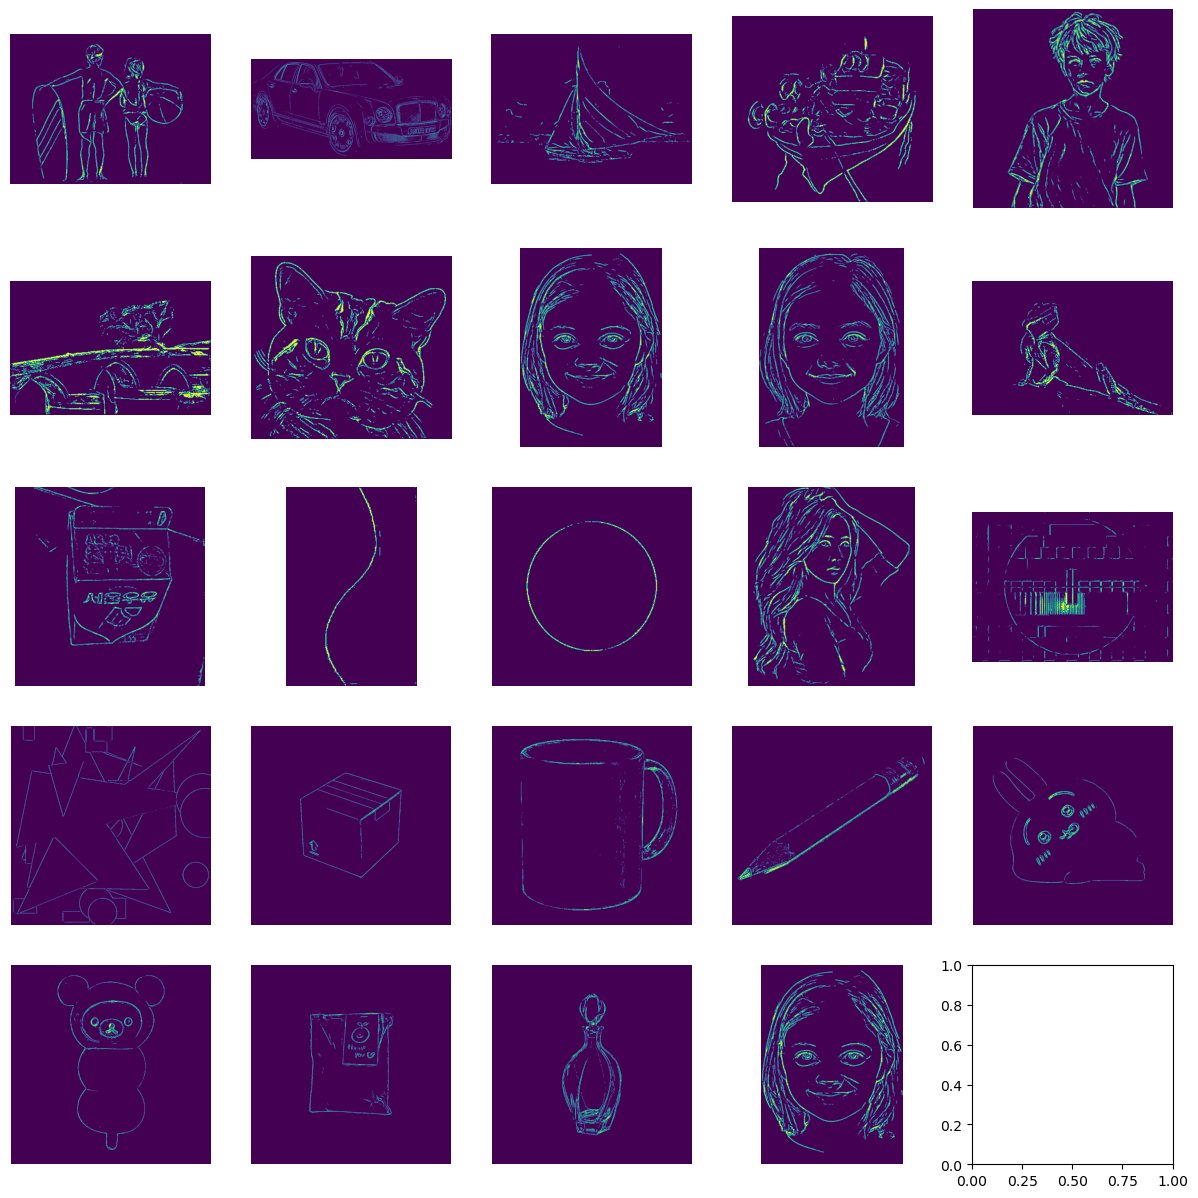

In [15]:
# 서브플롯 생성 및 이미지 표시 (위와 동일)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
for idx, ax in enumerate(axes.flat):
    ax.imshow(results_50[idx])
    ax.axis('off')

plt.tight_layout()
plt.show()

IndexError: list index out of range

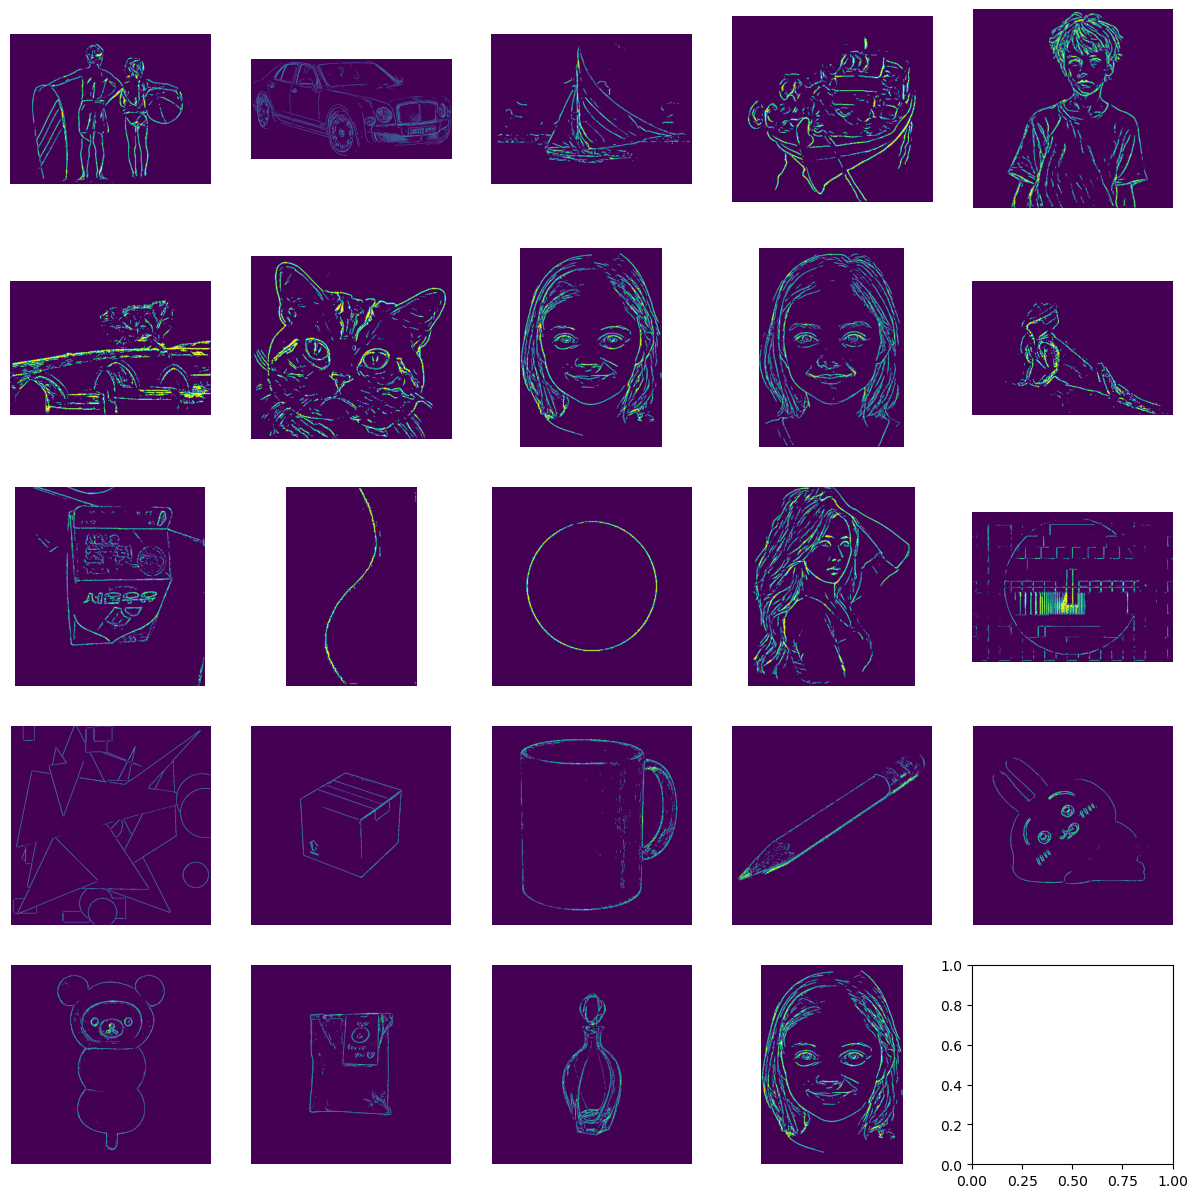

In [10]:
# 서브플롯 생성 및 이미지 표시 (위와 동일)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
for idx, ax in enumerate(axes.flat):
    ax.imshow(results_70[idx])
    ax.axis('off')

plt.tight_layout()
plt.show()

IndexError: list index out of range

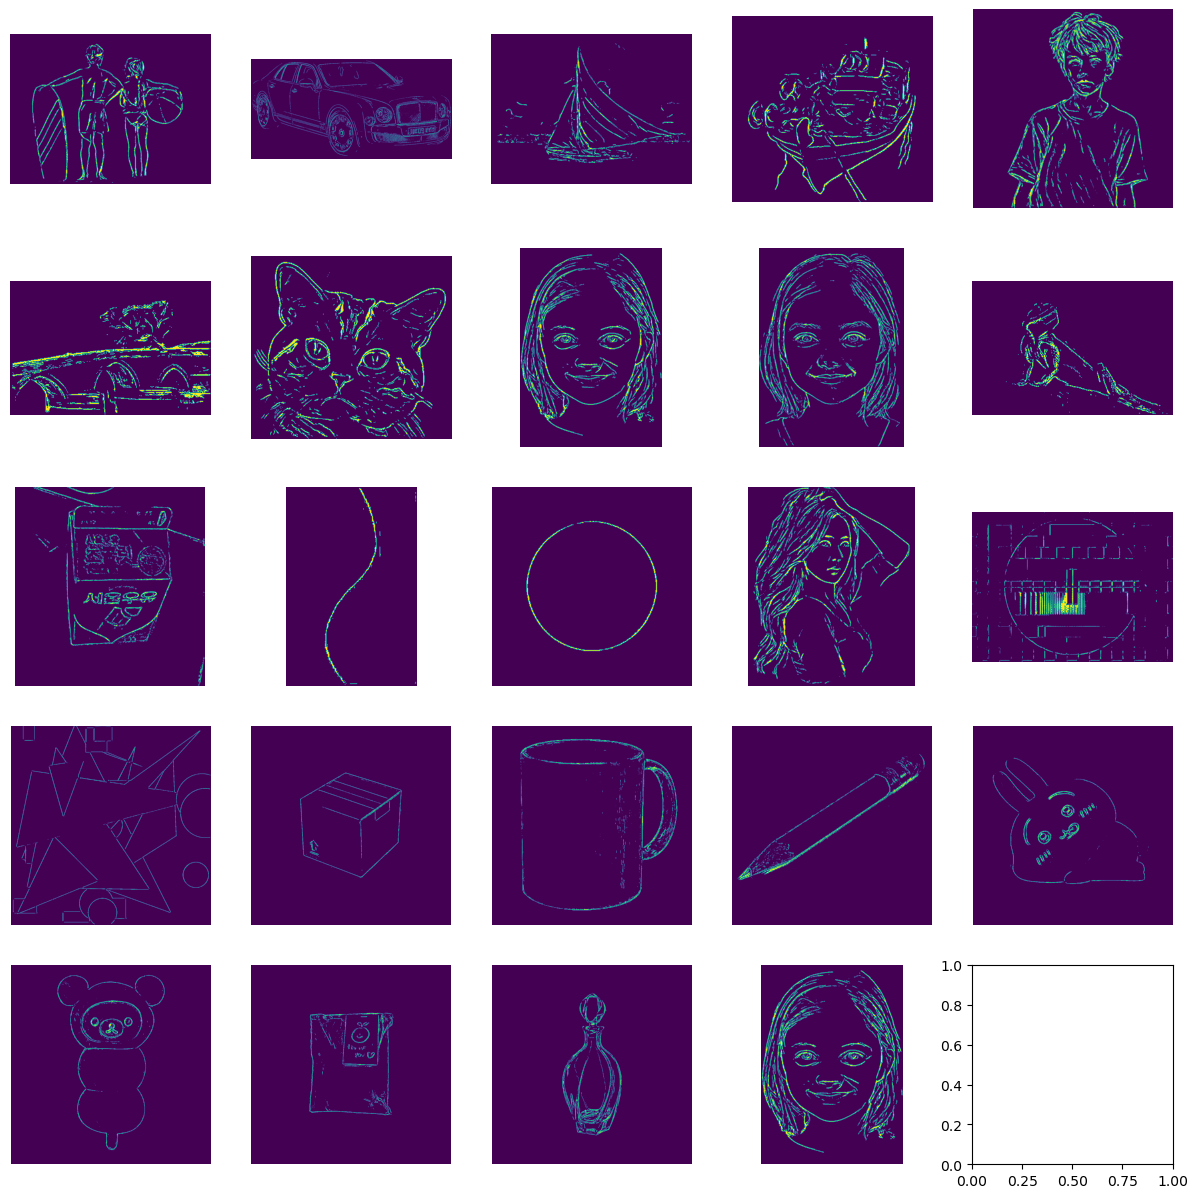

In [11]:
# 서브플롯 생성 및 이미지 표시 (위와 동일)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
for idx, ax in enumerate(axes.flat):
    ax.imshow(results_90[idx])
    ax.axis('off')

plt.tight_layout()
plt.show()

# 9. Generating gif images through iterations

In [57]:
import cv2
from src.models import FCNet

device = "cuda:0"
index = 1
threshold = 0.95

imgs = []

vtf = wind_dset[index]["vtf"]
infodraw = wind_dset[index]["infodraw"].squeeze().numpy()
img = wind_dset[index]["img"].permute([1, 2, 0]).numpy()

for i in tqdm(range(4, 62)):
    # Load model of each iterations
    model = FCNet()
    model.load_state_dict(torch.load(f"/home/work/joono/VTFSketch/weights/20241016/train3_model_full_train_enhance_iter_{i}.pth"))
    model = model.to(device)
    model.eval()
    
    vtf_tensor = torch.tensor(vtf).to(device)
        
    pred = model(vtf_tensor.unsqueeze(0))
    result = (1 - pred).squeeze().detach().cpu().numpy() > threshold
    result_3c = np.repeat(result[:, :, np.newaxis], 3, axis=2).astype(np.float32)
    cv2.putText(result_3c, f"{i}", (50, 50), cv2.FONT_HERSHEY_PLAIN, 2, (100, 100, 100), 2, 2)
    
    imgs.append(np.concatenate([result_3c, np.repeat(infodraw[:,:,np.newaxis], 3, axis=2), img], axis=1))

100%|██████████| 58/58 [00:09<00:00,  6.12it/s]


In [59]:
from PIL import Image

frames = [Image.fromarray((255*img).astype(np.uint8)) for img in imgs]
frames[0].save(
    "output.gif",
    format='GIF',
    append_images=frames[1:],
    save_all=True,
    duration=500,
    loop=0
)